In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [2]:
import re
import string
import nltk
from nltk.corpus import stopwords,words

import warnings 
warnings.filterwarnings("ignore")

In [3]:
pd.set_option("display.max_colwidth", 200)
sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['axes.titlesize'] = 20

In [4]:
train  = pd.read_csv('train_E6oV3lV.csv')
test = pd.read_csv('test_tweets_anuFYb8.csv')

In [5]:
print(train.shape,test.shape)
train.head()

(31962, 3) (17197, 2)


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [6]:
train.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [7]:
combi = pd.concat([train,test],axis=0).reset_index(drop=True)
combi.head()

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation


In [8]:
# Removing punctuation & Stopwords

stop_words = stopwords.words('english')

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'ve", " ", text)
    text = re.sub(r"i'm", " ", text)
    text = re.sub(r"\'re", " ", text)
    text = re.sub(r"\'d", " ", text)
    text = re.sub(r"\'ll", " ", text)
    text = re.sub('\n',' ',text) 
    text = re.sub('[^a-zA-Z#]', ' ', text)       #Removing punctuations but keeping hashtags
    text = re.sub('\s+', ' ', text)      
    text = ' '.join([i for i in text.split() if i not in stop_words])
    return text

In [9]:
combi['tweet'] = combi.tweet.apply(lambda x: clean_text(x))
combi.head()

,id,label,tweet
0,1,0.0,user father dysfunctional selfish drags kids dysfunction #run
1,2,0.0,user user thanks #lyft credit cannot use cause offer wheelchair vans pdx #disapointed #getthanked
2,3,0.0,bihday majesty
3,4,0.0,#model love u take u time ur
4,5,0.0,factsguide society #motivation


In [10]:
combi.tweet[3]

'#model love u take u time ur'

In [11]:
#TOKENIZATION and removing words less than 3 in length

from nltk.tokenize import word_tokenize
combi['tweet'] = combi.tweet.apply(lambda x: word_tokenize(x.lower())) #word tokenization
combi['tweet'] = combi.tweet.apply(lambda x: [i for i in x if len(i)>3])
combi.head()

,id,label,tweet
0,1,0.0,"[user, father, dysfunctional, selfish, drags, kids, dysfunction]"
1,2,0.0,"[user, user, thanks, lyft, credit, cause, offer, wheelchair, vans, disapointed, getthanked]"
2,3,0.0,"[bihday, majesty]"
3,4,0.0,"[model, love, take, time]"
4,5,0.0,"[factsguide, society, motivation]"


In [12]:
#LEMMATIZATION

from nltk.stem import WordNetLemmatizer

def split_into_lemmas(text):
    lemma = []
    lemmatizer = WordNetLemmatizer()
    for word in text:
        a = lemmatizer.lemmatize(word)
        lemma.append(a)
    return ' '.join(lemma)

combi['tweet'] = combi.tweet.apply(split_into_lemmas)
combi.head()

,id,label,tweet
0,1,0.0,user father dysfunctional selfish drag kid dysfunction
1,2,0.0,user user thanks lyft credit cause offer wheelchair van disapointed getthanked
2,3,0.0,bihday majesty
3,4,0.0,model love take time
4,5,0.0,factsguide society motivation


# Word Embedding using Word2Vec

In [13]:
from gensim.models import Word2Vec

In [14]:
token_tweet = combi.tweet.apply(lambda x: x.split()) 

w2v = Word2Vec(token_tweet, size=300, min_count=2, seed = 0) #plotting tokens in 300 dimensional space

In [15]:
def word_2_vec(token, dim):
    '''
    This function finds vector of each token present in a sentence and then averages to get the vector of whole sentence.
    '''
    cnt = 0
    vec = np.zeros(dim) 
        
    for word in token:
        try:
            vec += w2v[word]
            cnt += 1
        except KeyError:         
            continue
            
    if cnt != 0:
        vec /= cnt
    return vec

In [16]:
dim=300
w2v_mat = np.zeros((len(token_tweet), dim))
for i,token in enumerate(token_tweet):
    w2v_vec = word_2_vec(token,dim)
    w2v_mat[i] = w2v_vec

w2v_df = pd.DataFrame(w2v_mat)
print(w2v_df.shape)

(49159, 300)


In [17]:
train_w2v = w2v_df[:31962]
test_w2v = w2v_df[31962:]

In [18]:
X = train_w2v
y = train.label

# Model Building

Now we will build the model for predicting the sentiment of tweet using different algorithms mentioned below:

1. Logistic Regression
2. Naive Bayes 
3. K Nearest Neighbor
4. Support Vector Machine
5. Decision Tree
6. Random Forest
7. XGBoost
8. LightGBM

# 1. Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=1029)

In [21]:
model = LogisticRegression()
model.fit(X_train, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [26]:
y_pred = model.predict_proba(X_test) 
y_pred = y_pred[:,1] >= 0.3        # if prediction is greater than or equal to 0.3 than 1 else 0
y_pred = y_pred.astype(np.int)

print(f1_score(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

0.35772357723577236


[[2894   49]
 [ 188   66]]


              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2943
           1       0.57      0.26      0.36       254

   micro avg       0.93      0.93      0.93      3197
   macro avg       0.76      0.62      0.66      3197
weighted avg       0.91      0.93      0.91      3197



predicting test dataset tweets and creating submission file

In [27]:
test_pred = model.predict_proba(test_w2v)
test_pred = test_pred[:,1] >= 0.3
test_pred = test_pred.astype(np.int)

submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = test_pred
submission.to_csv('sub_W2V_LR.csv', index=False)

###### Public Leaderboard score:  0.3401109057301294

# 2. Naive Bayes

In [28]:
from sklearn import naive_bayes

In [29]:
model = naive_bayes.MultinomialNB()
model.fit(X_train, y_train)

ValueError: Input X must be non-negative

###### As the component of vectors for any tweet contain positive as well as negative values and hence Naive Bayes can't be used to create model.

# 3. K Nearest Neighbor

In [30]:
from sklearn.neighbors import KNeighborsClassifier

In [31]:
cv_scores=[]
for i in range(1,10):
    model = KNeighborsClassifier(n_neighbors = i)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_test,y_pred)
    cv_scores.append(score)

Text(0.5, 1.0, 'K vs F1 score')

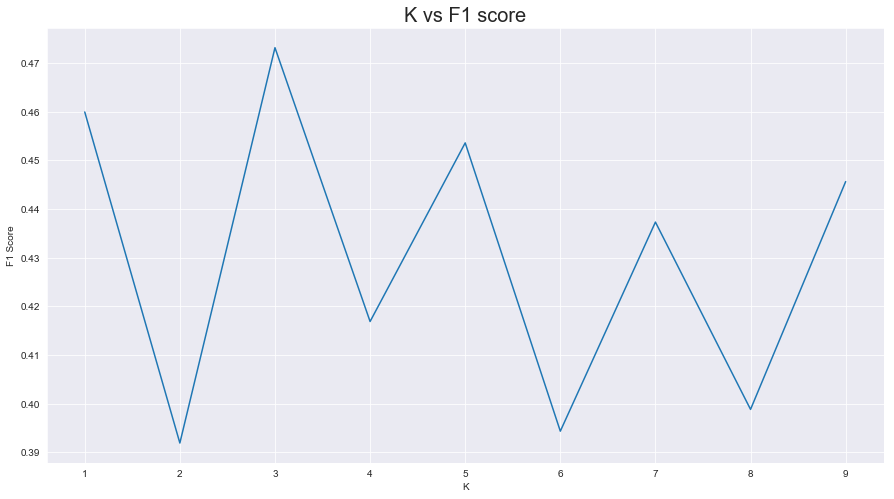

In [32]:
plt.plot(range(1,10),cv_scores)
plt.xlabel('K')
plt.ylabel('F1 Score')
plt.title('K vs F1 score')

From the above plot, it is clearly visible that our model is not performing very well. To choose from the available option f1_score is maximum for K = 3 and hence choosing K = 3 for building the model.

In [33]:
model = KNeighborsClassifier(n_neighbors = 3)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(f1_score(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

0.47317073170731705


[[2884   59]
 [ 157   97]]


              precision    recall  f1-score   support

           0       0.95      0.98      0.96      2943
           1       0.62      0.38      0.47       254

   micro avg       0.93      0.93      0.93      3197
   macro avg       0.79      0.68      0.72      3197
weighted avg       0.92      0.93      0.92      3197



predicting test dataset tweets and creating submission file

In [34]:
test_pred = model.predict(test_w2v)

submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = test_pred
submission.to_csv('sub_W2V_KNN.csv', index=False)

###### Public Leaderboard score :  0.4486571879936809

# 4. Support Vector Machine

In [35]:
from sklearn import svm

In [36]:
model = svm.SVC(kernel='linear', C=10, probability=True)
model.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [37]:
y_pred = model.predict_proba(X_test) 
y_pred = y_pred[:,1] >= 0.3        # if prediction is greater than or equal to 0.3 than 1 else 0
y_pred = y_pred.astype(np.int)

print(f1_score(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

0.4804177545691906


[[2906   37]
 [ 162   92]]


              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2943
           1       0.71      0.36      0.48       254

   micro avg       0.94      0.94      0.94      3197
   macro avg       0.83      0.67      0.72      3197
weighted avg       0.93      0.94      0.93      3197



In [38]:
test_pred = model.predict_proba(test_w2v)
test_pred = test_pred[:,1] >= 0.3   
test_pred = test_pred.astype(np.int)

submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = test_pred
submission.to_csv('sub_W2V_SVM.csv', index=False)

###### Public Leaderboard score :  0.4253075571177504

# 5. Decision Tree

In [39]:
from sklearn.tree import DecisionTreeClassifier

In [40]:
model = DecisionTreeClassifier(criterion='entropy',min_samples_split =10,max_features=300)
model.fit(X_train,y_train)  

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=300, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [41]:
y_pred = model.predict(X_test)

print(f1_score(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

0.38493723849372385


[[2811  132]
 [ 162   92]]


              precision    recall  f1-score   support

           0       0.95      0.96      0.95      2943
           1       0.41      0.36      0.38       254

   micro avg       0.91      0.91      0.91      3197
   macro avg       0.68      0.66      0.67      3197
weighted avg       0.90      0.91      0.91      3197



In [42]:
test_pred = model.predict(test_w2v)

submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = test_pred
submission.to_csv('sub_W2V_DTree.csv', index=False)

###### Public Leaderboard score :  0.43556701030927836

# 6. Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
model = RandomForestClassifier(n_estimators=40,criterion='entropy',min_samples_split =5,max_features=300)
model.fit(X_train,y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=300, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [45]:
y_pred = model.predict(X_test)

print(f1_score(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

0.4806629834254143


[[2922   21]
 [ 167   87]]


              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2943
           1       0.81      0.34      0.48       254

   micro avg       0.94      0.94      0.94      3197
   macro avg       0.88      0.67      0.72      3197
weighted avg       0.93      0.94      0.93      3197



In [46]:
test_pred = model.predict(test_w2v)

submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = test_pred
submission.to_csv('sub_W2V_RF.csv', index=False)

###### Public Leaderboard score :  0.48339483394833943

# 7. XGBoost

In [47]:
import xgboost as xgb

In [48]:
model = xgb.XGBClassifier(n_estimators=200,max_depth=30,min_child_weight=5,subsample=0.8,colsample_bytree=0.7)
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, colsample_bytree=0.7, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=30,
       min_child_weight=5, n_estimators=200, nthread=-1,
       objective='binary:logistic', seed=0, silent=True, subsample=0.8)

In [49]:
y_pred = model.predict(X_test)

print(f1_score(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

0.5416666666666666


[[2917   26]
 [ 150  104]]


              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2943
           1       0.80      0.41      0.54       254

   micro avg       0.94      0.94      0.94      3197
   macro avg       0.88      0.70      0.76      3197
weighted avg       0.94      0.94      0.94      3197



In [50]:
test_pred = model.predict(test_w2v)

submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = test_pred
submission.to_csv('sub_W2V_XGB.csv', index=False)

###### Public Leaderboard score : 0.49735449735449727

# 8. LightGBM

In [51]:
import lightgbm as lgb

In [52]:
model = lgb.LGBMClassifier(n_estimators=200,max_depth=30,min_child_weight=5,subsample=0.8,colsample_bytree=0.7)
model.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
        importance_type='split', learning_rate=0.1, max_depth=30,
        min_child_samples=20, min_child_weight=5, min_split_gain=0.0,
        n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [53]:
y_pred = model.predict(X_test)

print(f1_score(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

0.510752688172043


[[2920   23]
 [ 159   95]]


              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2943
           1       0.81      0.37      0.51       254

   micro avg       0.94      0.94      0.94      3197
   macro avg       0.88      0.68      0.74      3197
weighted avg       0.94      0.94      0.93      3197



In [54]:
test_pred = model.predict(test_w2v)

submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = test_pred
submission.to_csv('sub_W2V_LGBM.csv', index=False)

###### Public Leaderboard score :  0.5008944543828264

| Algorithm | Model F1 Score | Public F1 Score |
| --------- | ---------- | ------------------- |
| Logistic Regression | 0.35772357723577236 | 0.3401109057301294  |
| K Nearest Neighbor | 0.47317073170731705 | 0.4486571879936809 |
| SVM | 0.4804177545691906  | 0.4253075571177504 |
| Decision Tree | 0.38493723849372385  | 0.43556701030927836 |
| Random Forest | 0.4806629834254143 | 0.48339483394833943  |
| XGBoost | 0.5416666666666666 | 0.49735449735449727 |
| LightGBM | 0.510752688172043  |  0.5008944543828264 |